# Models Analysis

In [1]:
import json
import pandas as pd
import statistics as stats
import re
import pprint
import matplotlib.pyplot as plt

In [2]:
ALL_TABULAR_DATASETS = ["adult", "census", "child", "covtype", "credit", "insurance", 
                       "health_insurance", "intrusion", "drugs", "loan", "pums"]
ALL_TABULAR_MODELS = {
    "gretel": ["actgan"], 
    "sdv": ["ctgan", "tvae", "gaussian_copula"], 
    "syn": ["ctgan", "tvae", "goggle", "arf", "ddpm", "nflow", "rtvae"], 
    "llm": ["great"], 
    "betterdata": ["gan", "gan_dp"]
}

ALL_SEQUENTIAL_DATASETS = ["taxi", "nasdaq", "pums"]

ALL_SEQUENTIAL_MODELS = {
    "gretel": ["dgan"],
    "sdv": ["par"]
}

### Jobs evaluation

In [3]:
def get_cmds_configs(command_string):

    # Sample command string
    # command_string = "python3 run_model.py --m sequential --l sdv --s par --data nasdaq --o outputs --run_model_training --use_gpu"

    # Regular expression pattern to extract arguments for "--l", "--s", and "--data"
    pattern = r"--l (\S+).*?--s (\S+).*?--data (\S+)"

    # Use regex to find the match
    match = re.search(pattern, command_string)

    # Extract values from the match
    library = match.group(1) if match else None
    synthesizer = match.group(2) if match else None
    data = match.group(3) if match else None

    return (library, synthesizer, data)

In [4]:
sdg_jobs_df = pd.read_csv("../final_outs/sdg_jobs.csv")
if 'Unnamed: 0' in sdg_jobs_df.columns:
    sdg_jobs_df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
sdg_jobs_df.columns

Index(['Experiment Name', 'Run ID', 'Status', 'Creation Time', 'End Time',
       'Duration (seconds)', 'Compute Target', 'Command Parameters'],
      dtype='object')

In [6]:
# sdg_jobs_df[["Command Parameters"]]

### Incompleted jobs -- Failed, Canceled, Running

In [7]:
# Iterate over rows and print 'Command Parameters' for specific 'Status' values
TABULAR_INCOMPLETE_JOBS = {
    "gretel": {}, 
    "sdv": {}, 
    "syn": {}
}
for index, row in sdg_jobs_df.iterrows():
    if row['Status'] in ['Failed', 'Canceled', 'Running']:
        (library, synthesizer, data) = get_cmds_configs(row['Command Parameters'])
        if library and synthesizer and data:
            # print(library, synthesizer, data)
            
            if library == "synthcity":
                library = "syn"
            
            if synthesizer in TABULAR_INCOMPLETE_JOBS[library]:
                TABULAR_INCOMPLETE_JOBS[library][synthesizer][data] = row['Status']
            else:
                TABULAR_INCOMPLETE_JOBS[library][synthesizer] = {}
                TABULAR_INCOMPLETE_JOBS[library][synthesizer][data] = row['Status']
                
                
pprint.pprint(TABULAR_INCOMPLETE_JOBS)

{'gretel': {'dgan': {'pums': 'Failed'}},
 'sdv': {'ctgan': {'insurance': 'Failed'}, 'par': {'pums': 'Failed'}},
 'syn': {'arf': {'pums': 'Failed'},
         'ctgan': {'covtype': 'Running',
                   'credit': 'Canceled',
                   'pums': 'Failed'},
         'ddpm': {'pums': 'Canceled'},
         'goggle': {'adult': 'Failed',
                    'covtype': 'Failed',
                    'intrusion': 'Failed',
                    'loan': 'Failed',
                    'pums': 'Running'},
         'nflow': {'adult': 'Failed',
                   'covtype': 'Failed',
                   'loan': 'Failed',
                   'pums': 'Failed'},
         'rtvae': {'credit': 'Canceled', 'pums': 'Failed'},
         'tvae': {'pums': 'Failed'}}}


In [8]:
ERROR_VAL  = -99
def get_scores_df(exp_dataset, models_list, case="tabular", all_jobs=False):
    
    final_report = {
        "dataset": [], 
        "model": [],
        "case": [], 
        "domain_cov": [], 
        "stats_cov": [], 
        "outliers_cov": [],
        "missing_cov": [],
        "ks_sim": [], 
        "tv_sim": [],
        "corr_sim": [], 
        "contin_sim": [], 
        "avg_quality": [],
        "wass_dist": [], 
        "js_dist": [], 
        "new_rows": []
    }


    for lib, models in models_list.items():
        
        if case == "hpo" and lib!= "syn":
            continue
        for model in models: 
            
            if case in ["hyperimpute", "ice", "missforest", "simple", "only_hyperimpute", "only_ice", "only_missforest", "only_simple",]:  
                corr_file = f"../metrics_out/hyperimpute/{model}_{lib}/{exp_dataset}/{case}/{exp_dataset}_{model}_correlation.csv"
                metrics_file = f"../metrics_out/hyperimpute/{model}_{lib}/{exp_dataset}/{case}/{exp_dataset}_{model}_metrics.json"
            else:
                corr_file = f"../metrics_out/{case}/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_correlation.csv"
                metrics_file = f"../metrics_out/{case}/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_metrics.json"
                        
            try:
                with open(metrics_file, 'r') as file:
                    metrics_scores = json.load(file)
                corr_df = pd.read_csv(corr_file)
                # print("Success:", metrics_file)
            except Exception as e:
                # print(e)
                if all_jobs:
                    # print(model, lib)
                    status = None
                    if lib in TABULAR_INCOMPLETE_JOBS and model in TABULAR_INCOMPLETE_JOBS[lib]:
                        if exp_dataset in TABULAR_INCOMPLETE_JOBS[lib][model]:
                            # print("Status: ",  TABULAR_INCOMPLETE_JOBS[lib][model][exp_dataset])
                            # print("-")
                            status = TABULAR_INCOMPLETE_JOBS[lib][model][exp_dataset]
                        else:
                            status = -99 #"Skipped"
                    else:
                        status =  -99 #"Skipped"
                        # print(e)
                        # print("Skipped")
                    for k in final_report.keys():
                        if k not in ["model", "dataset", "case"]: 
                            final_report[k].append(ERROR_VAL) #.append(status)
                        # print(final_report)
                    
                continue
            
            final_report["model"].append(f"{model}_{lib}")
            final_report["dataset"].append(exp_dataset)
            final_report["case"].append(case)
            
            #----------------------
            # Domain Coverage
            #----------------------
            if metrics_scores["coverage"]["domain_coverage"].values():
                domain_coverage_mean = round(stats.mean(metrics_scores["coverage"]["domain_coverage"].values()), 2)
                final_report["domain_cov"].append(domain_coverage_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["domain_cov"].append(ERROR_VAL)  # or any other default value

            #----------------------
            # Missing values Coverage
            #----------------------
            if metrics_scores["coverage"]["missing_values_coverage"].values():
                missing_values_coverage_mean = round(stats.mean(metrics_scores["coverage"]["missing_values_coverage"].values()), 2)
                final_report["missing_cov"].append(missing_values_coverage_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["missing_cov"].append(ERROR_VAL)  # or any other default value

            #----------------------
            # Outliers Coverage
            #----------------------
            if metrics_scores["coverage"]["outlier_coverage"].values():
                outlier_coverage_mean = round(stats.mean(metrics_scores["coverage"]["outlier_coverage"].values()), 2)
                final_report["outliers_cov"].append(outlier_coverage_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["outliers_cov"].append(ERROR_VAL)  # or any other default value
            
            #----------------------
            # Statistics Similarity
            #----------------------
            # Initialize total and count variables
            total_average = 0
            count = 0
            # Calculate the average of mean, median, and std for each column
            try:
                for c, s in metrics_scores["similarity"]["statistic"].items():
                    column_average = (s["mean"] + s["median"] + s["std"]) / 3
                    total_average += column_average
                    count += 1
                # Calculate the overall average
                overall_average = total_average / count if count > 0 else ERROR_VAL
                final_report["stats_cov"].append(round(overall_average, 2))
            except:
                final_report["stats_cov"].append(ERROR_VAL)

            #---------------------------
            # KSComplement & TVComplement
            #---------------------------
            ks_scores = []
            tv_scores = []
            for key, value in metrics_scores["sdv_quality_report"]["distribution"].items():
                if value["metric"] == "KSComplement":
                    ks_scores.append(value["score"])
                elif value["metric"] == "TVComplement":
                    tv_scores.append(value["score"])

            # Calculating averages
            ks_average = stats.mean(ks_scores) if ks_scores else ERROR_VAL
            tv_average = stats.mean(tv_scores) if tv_scores else ERROR_VAL
            final_report["ks_sim"].append(round(ks_average, 2))
            final_report["tv_sim"].append(round(tv_average, 2))

            #--------------------------------------------
            # contingency_average, correlation_average
            #--------------------------------------------
            contingency_average = corr_df[corr_df['Metric'] == 'ContingencySimilarity']["Score"].mean()
            correlation_average = corr_df[corr_df['Metric'] == 'CorrelationSimilarity']["Score"].mean()

            final_report["contin_sim"].append(round(contingency_average, 2))
            final_report["corr_sim"].append(round(correlation_average, 2))

            #--------------------------------------------
            # SDV quality report
            #--------------------------------------------
            final_report["avg_quality"].append(round(metrics_scores["sdv_quality_report"]["score"], 2))
            
            #--------------------------------------------
            # Jensen Shannon Distance
            #--------------------------------------------
            if metrics_scores["similarity"]["js_distance"].values():
                js_dist_mean = round(stats.mean(metrics_scores["similarity"]["js_distance"].values()), 2)
                final_report["js_dist"].append(js_dist_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["js_dist"].append(ERROR_VAL)  # or any other default value
                
            #--------------------------------------------
            # Wassertein Distance
            #--------------------------------------------
            if metrics_scores["similarity"]["wass_distance"].values():
                wass_dist_mean = round(stats.mean(metrics_scores["similarity"]["wass_distance"].values()), 2)
                final_report["wass_dist"].append(wass_dist_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["wass_dist"].append(ERROR_VAL)  # or any other default value

            #--------------------------------------------
            # Privacy: New row synthesis
            #--------------------------------------------
            if "score" in metrics_scores["privacy"]["new_row_synthesis"]:
                final_report["new_rows"].append(round(metrics_scores["privacy"]["new_row_synthesis"]["score"], 2))
            else:
                final_report["new_rows"].append(ERROR_VAL)
            
    return final_report

### Standard tabular datasets 

In [9]:
std_tabular_df = pd.DataFrame()
for exp_dataset in ALL_TABULAR_DATASETS:
    final_report = get_scores_df(exp_dataset, ALL_TABULAR_MODELS, "tabular", False) 
    std_tabular_df = pd.concat([std_tabular_df, pd.DataFrame(final_report)], ignore_index=True)
std_tabular_df

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
0,adult,actgan_gretel,tabular,0.89,0.99,0.49,1.00,0.79,0.92,0.97,0.87,0.88,0.02,0.24,1.00
1,adult,ctgan_sdv,tabular,0.87,0.99,0.79,1.00,0.87,0.91,0.98,0.82,0.87,0.02,0.22,1.00
2,adult,tvae_sdv,tabular,0.79,0.99,0.68,1.00,0.88,0.94,0.97,0.88,0.91,0.02,0.13,1.00
3,adult,gaussian_copula_sdv,tabular,0.92,0.95,0.41,1.00,0.70,0.80,0.99,0.73,0.76,0.07,0.29,1.00
4,adult,ctgan_syn,tabular,0.91,0.99,0.49,1.00,0.76,0.79,0.98,0.74,0.78,0.02,0.34,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,loan,gan_dp_betterdata,tabular,0.99,0.98,0.35,1.00,0.92,0.95,0.91,0.73,0.85,0.02,0.16,1.00
101,pums,actgan_gretel,tabular,0.81,0.99,0.60,0.98,0.85,0.98,0.97,0.91,0.92,0.01,0.20,0.99
102,pums,ctgan_sdv,tabular,0.82,0.99,0.67,1.00,0.88,0.99,0.99,0.94,0.95,0.01,0.19,1.00
103,pums,tvae_sdv,tabular,0.80,0.97,0.63,1.00,0.81,0.92,0.95,0.82,0.86,0.04,0.29,1.00


### Imputation -- imputed data and generated synthetic data (with imputation)

In [10]:
ALL_HYPERIMPUTE_MODELS = {
    "sdv": ["ctgan"]
}

IMPUTERS = ["missforest", "ice", "hyperimpute", "simple"]

tabular_impute_df = pd.DataFrame()
for imputer in IMPUTERS:
    final_report = get_scores_df("drugs", ALL_HYPERIMPUTE_MODELS, imputer, True)
    tabular_impute_df = pd.concat([tabular_impute_df, pd.DataFrame(final_report)], ignore_index=True)
    
    final_report = get_scores_df("drugs", ALL_HYPERIMPUTE_MODELS, "only_" + imputer, True)
    tabular_impute_df = pd.concat([tabular_impute_df, pd.DataFrame(final_report)], ignore_index=True)
    
tabular_impute_df

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
0,drugs,ctgan_sdv,missforest,0.92,0.99,0.0,0.42,0.95,0.88,0.92,0.17,0.53,0.01,0.07,-99
1,drugs,ctgan_sdv,only_missforest,0.93,1.00,1.0,0.42,0.98,0.91,0.97,0.19,0.55,0.01,0.05,-99
2,drugs,ctgan_sdv,ice,0.96,0.93,0.0,0.42,0.90,0.89,0.95,0.17,0.53,0.09,0.22,-99
3,drugs,ctgan_sdv,only_ice,0.96,1.00,1.0,0.42,0.98,0.92,0.97,0.19,0.56,0.01,0.05,-99
4,drugs,ctgan_sdv,hyperimpute,0.95,0.92,1.0,0.42,0.85,0.90,0.96,0.17,0.53,0.12,0.27,-99
5,drugs,ctgan_sdv,only_hyperimpute,0.95,1.00,1.0,0.42,0.98,0.92,0.97,0.19,0.56,0.01,0.05,-99
6,drugs,ctgan_sdv,simple,0.90,0.98,0.0,0.42,0.94,0.89,0.96,0.17,0.53,0.03,0.10,-99
7,drugs,ctgan_sdv,only_simple,0.91,1.00,1.0,0.42,0.98,0.92,0.97,0.19,0.56,0.01,0.05,-99


### Hyperparameter optimisation

In [11]:
# exp_dataset = "adult"
HPO_DATASETS = ["adult", "loan"]
hpo_df = pd.DataFrame()
for exp_dataset in HPO_DATASETS:
    final_report = get_scores_df(exp_dataset, ALL_TABULAR_MODELS, "hpo", False)
    hpo_df = pd.concat([hpo_df, pd.DataFrame(final_report)], ignore_index=True)
hpo_df

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
0,adult,ctgan_syn,hpo,0.94,0.99,0.59,1.0,0.80,0.83,0.98,0.76,0.81,0.01,0.27,1.0
1,adult,tvae_syn,hpo,0.92,0.99,0.57,1.0,0.90,0.85,0.99,0.80,0.85,0.01,0.19,1.0
2,adult,arf_syn,hpo,0.98,1.00,0.81,1.0,0.90,0.92,0.99,0.87,0.90,0.01,0.16,1.0
3,adult,ddpm_syn,hpo,0.99,1.00,0.72,1.0,0.98,0.97,0.99,0.94,0.96,0.01,0.07,1.0
4,adult,rtvae_syn,hpo,0.96,0.98,0.95,1.0,0.84,0.80,0.96,0.74,0.79,0.03,0.23,1.0
5,loan,ctgan_syn,hpo,0.97,0.99,0.40,1.0,0.91,0.98,0.96,0.93,0.94,0.03,0.17,1.0
6,loan,tvae_syn,hpo,0.95,0.98,0.35,1.0,0.93,0.98,0.96,0.92,0.94,0.02,0.19,1.0
7,loan,arf_syn,hpo,1.00,0.99,0.46,1.0,0.90,0.99,0.98,0.93,0.94,0.02,0.14,1.0
8,loan,ddpm_syn,hpo,1.00,0.94,0.45,1.0,0.95,0.97,0.98,0.88,0.93,0.03,0.10,1.0
9,loan,rtvae_syn,hpo,0.87,0.97,0.35,1.0,0.87,0.98,0.94,0.81,0.88,0.04,0.47,1.0


## Machine learning efficacy metrics

In [12]:
ML_CLASSIFICATION_TASK_DATASETS = [
    "adult", "census", "credit", "covtype", "loan", "intrusion"]
ML_REGRESSION_TASK_DATASETS = ["health_insurance"]

ERROR_VAL  = -99
def get_ml_scores_df(exp_dataset, report, metric, case="tabular"):
    for lib, models in ALL_TABULAR_MODELS.items():
        for model in models: 
            metrics_file = f"../metrics_out/{case}/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_metrics.json"
            try:
                with open(metrics_file, 'r') as file:
                    metrics_scores = json.load(file)
            except Exception as e:
                # print(e)
                # print(model, lib)
                # status = None
                # if lib in TABULAR_INCOMPLETE_JOBS and model in TABULAR_INCOMPLETE_JOBS[lib]:
                #     if exp_dataset in TABULAR_INCOMPLETE_JOBS[lib][model]:
                #         # print("Status: ",  TABULAR_INCOMPLETE_JOBS[lib][model][exp_dataset])
                #         # print("-")
                #         status = TABULAR_INCOMPLETE_JOBS[lib][model][exp_dataset]
                #     else:
                #         status = "Skipped"
                # else:
                #     status = "Skipped"
                #     # print(e)
                #     # print("Skipped")
                # for k in report.keys():
                #     if k not in ["model", "dataset", "case"]: 
                #         report[k].append(status)
                #     # print(final_report)
                continue
                
            report["dataset"].append(exp_dataset)
            report["model"].append(f"{model}_{lib}")
            report["case"].append(case)
            
            for k, v in report.items():
                if k in ["dataset", "model", "case"] or "diff" in k:
                    continue   

                try:
                    scores = metrics_scores["ml_efficacy"][k]
                    report[k].append(round(scores[f"synthetic_{metric}"], 2))
                    report[f"{k}_diff"].append(round(abs(scores[f"synthetic_{metric}"] - scores[f"real_{metric}"]), 2))
                except:
                    report[k].append(ERROR_VAL)
                    report[f"{k}_diff"].append(ERROR_VAL)
                
#     for k, v in report.items():
#         print(k, len(v))
    return report

### Classification

In [13]:
final_report_ml_cls = {
    "dataset": [],  
    "model": [],
    "case": [], 
    "adaboost_classification": [], 
    "adaboost_classification_diff": [],
    "decision_tree_classification": [], 
    "decision_tree_classification_diff": [], 
    "logistic_classification": [],
    "logistic_classification_diff": [],
    "mlp_classification": [],
    "mlp_classification_diff": []
}
ml_cls_metric = "f1"

tabular_ml_cls_df = pd.DataFrame()
for exp_dataset in ML_CLASSIFICATION_TASK_DATASETS:
    final_report = get_ml_scores_df(exp_dataset, final_report_ml_cls, ml_cls_metric, "tabular")
    tabular_ml_cls_df = pd.concat([tabular_ml_cls_df, pd.DataFrame(final_report)], ignore_index=True)
    
tabular_ml_cls_df 

,dataset,model,case,adaboost_classification,adaboost_classification_diff,decision_tree_classification,decision_tree_classification_diff,logistic_classification,logistic_classification_diff,mlp_classification,mlp_classification_diff
0,adult,actgan_gretel,tabular,0.88,0.03,0.85,0.01,0.83,0.05,0.88,0.02
1,adult,ctgan_sdv,tabular,0.90,0.01,0.83,0.03,0.83,0.05,0.89,0.01
2,adult,tvae_sdv,tabular,0.89,0.01,0.84,0.02,0.82,0.05,0.86,0.03
3,adult,gaussian_copula_sdv,tabular,0.88,0.02,0.75,0.11,0.81,0.06,0.87,0.03
4,adult,ctgan_syn,tabular,0.87,0.04,0.77,0.08,0.81,0.06,0.86,0.02
...,...,...,...,...,...,...,...,...,...,...,...
197,intrusion,tvae_sdv,tabular,1.00,0.00,0.99,0.01,1.00,0.03,1.00,0.00
198,intrusion,gaussian_copula_sdv,tabular,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00
199,intrusion,ctgan_syn,tabular,0.99,0.01,0.98,0.02,0.98,0.01,0.99,0.01
200,intrusion,tvae_syn,tabular,1.00,0.00,1.00,0.00,0.97,0.00,1.00,0.00


### Regression

In [14]:
final_report_ml_regress = {
    "dataset": [],  
    "model": [],
    "case": [],
    "linear_regression": [],
    "linear_regression_diff": [], 
    "mlp_regression": [],
    "mlp_regression_diff": []
}

ml_regress_metric = "r2"
tabular_ml_reg_df = pd.DataFrame()
for exp_dataset in ML_REGRESSION_TASK_DATASETS:
    final_report = get_ml_scores_df(exp_dataset, final_report_ml_regress, ml_regress_metric, "tabular")
    tabular_ml_reg_df = pd.concat([tabular_ml_reg_df, pd.DataFrame(final_report)], ignore_index=True)
    
tabular_ml_reg_df 

,dataset,model,case,linear_regression,linear_regression_diff,mlp_regression,mlp_regression_diff
0,health_insurance,actgan_gretel,tabular,0.16,0.55,-1.32,0.01
1,health_insurance,ctgan_sdv,tabular,-0.19,0.90,-1.32,0.01
2,health_insurance,tvae_sdv,tabular,0.58,0.12,-1.27,0.01
3,health_insurance,gaussian_copula_sdv,tabular,0.41,0.31,-1.31,0.01
4,health_insurance,ctgan_syn,tabular,0.71,0.00,-1.32,0.01
5,health_insurance,tvae_syn,tabular,0.66,0.05,-1.32,0.01
6,health_insurance,goggle_syn,tabular,-0.05,0.44,-2.03,0.02
7,health_insurance,arf_syn,tabular,0.71,0.00,-1.32,0.01
8,health_insurance,ddpm_syn,tabular,0.44,0.27,-1.32,0.01
9,health_insurance,nflow_syn,tabular,0.61,0.10,-1.32,0.01


# Anlaysis

In [16]:
# merge dataframes 
all_df = pd.DataFrame()
for df in [std_tabular_df, tabular_impute_df, hpo_df]:
    all_df = pd.concat([all_df, df], ignore_index=True)

# std_tabular_df
# tabular_impute_df
# hpo_df
# seq_df

# execution_scores_df

# tabular_ml_reg_df
# tabular_ml_cls_df  
all_df

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
0,adult,actgan_gretel,tabular,0.89,0.99,0.49,1.0,0.79,0.92,0.97,0.87,0.88,0.02,0.24,1.0
1,adult,ctgan_sdv,tabular,0.87,0.99,0.79,1.0,0.87,0.91,0.98,0.82,0.87,0.02,0.22,1.0
2,adult,tvae_sdv,tabular,0.79,0.99,0.68,1.0,0.88,0.94,0.97,0.88,0.91,0.02,0.13,1.0
3,adult,gaussian_copula_sdv,tabular,0.92,0.95,0.41,1.0,0.70,0.80,0.99,0.73,0.76,0.07,0.29,1.0
4,adult,ctgan_syn,tabular,0.91,0.99,0.49,1.0,0.76,0.79,0.98,0.74,0.78,0.02,0.34,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,loan,ctgan_syn,hpo,0.97,0.99,0.40,1.0,0.91,0.98,0.96,0.93,0.94,0.03,0.17,1.0
119,loan,tvae_syn,hpo,0.95,0.98,0.35,1.0,0.93,0.98,0.96,0.92,0.94,0.02,0.19,1.0
120,loan,arf_syn,hpo,1.00,0.99,0.46,1.0,0.90,0.99,0.98,0.93,0.94,0.02,0.14,1.0
121,loan,ddpm_syn,hpo,1.00,0.94,0.45,1.0,0.95,0.97,0.98,0.88,0.93,0.03,0.10,1.0


In [17]:
all_df.to_csv("tabular_benchmarks.csv")

In [18]:
all_df.columns 

Index(['dataset', 'model', 'case', 'domain_cov', 'stats_cov', 'outliers_cov',
       'missing_cov', 'ks_sim', 'tv_sim', 'corr_sim', 'contin_sim',
       'avg_quality', 'wass_dist', 'js_dist', 'new_rows'],
      dtype='object')

In [19]:
all_df["case"].unique()

array(['tabular', 'missforest', 'only_missforest', 'ice', 'only_ice',
       'hyperimpute', 'only_hyperimpute', 'simple', 'only_simple', 'hpo'],
      dtype=object)

In [20]:
all_df["dataset"].unique()

array(['adult', 'census', 'child', 'covtype', 'credit', 'insurance',
       'health_insurance', 'intrusion', 'drugs', 'loan', 'pums'],
      dtype=object)

In [21]:
ORANGE = "#f0dc82"
GREEN = "#90EE90"
YELLOW = "#91A3B0"

def highlight_top3_min3(s, skip_cols, min_cols, dummy_val=-99):
    '''
    Highlight the top 3 unique numerical values in each column with different colors.
    Highlight the smallest 3 unique values in specified columns.
    Skip specified columns and a specific dummy value.
    '''
    # Filter out the dummy value
    filtered_s = s[s != dummy_val]

    if s.name in min_cols:
        # Find the smallest 3 unique values for specified columns
        unique_bottom_values = filtered_s.drop_duplicates().nsmallest(3)
        return [f'background-color: {GREEN}' if v == unique_bottom_values.iloc[0] else
                f'background-color: {ORANGE}' if v == unique_bottom_values.iloc[1] else
                f'background-color: {YELLOW}' if v == unique_bottom_values.iloc[2] else ''
                for v in s]
    elif s.name not in skip_cols:
        # Find the top 3 unique values for other columns
        unique_top_values = filtered_s.drop_duplicates().nlargest(3)
        return [f'background-color: {GREEN}' if v == unique_top_values.iloc[0] else
                f'background-color: {ORANGE}' if v == unique_top_values.iloc[1] else
                f'background-color: {YELLOW}' if v == unique_top_values.iloc[2] else ''
                for v in s]
    else:
        return ['' for _ in s]  # Return empty styling for skipped columns

def get_styled_df(df, skip_cols, min_cols):    
    df_styled = df.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
    
    format_cols = {}
    for col in df.columns:
        if col not in skip_cols or col in min_cols:
            format_cols[col] = '{:.2f}'
    # df_styled = 
    return df_styled.format(format_cols)


In [22]:
skip_cols = ['dataset', 'model', 'case']
min_cols = ["wass_dist", "js_dist"]

### Hyperparameter optimisation analysis

### ctgan | loan & adult

In [34]:
subset = all_df[(all_df["model"] == "ctgan_syn") & (all_df["dataset"] == "loan")]
get_styled_df(subset, skip_cols, min_cols)

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
91,loan,ctgan_syn,tabular,0.96,0.96,0.49,1.00,0.87,0.96,0.98,0.85,0.90,0.05,0.21,1.00
118,loan,ctgan_syn,hpo,0.97,0.99,0.40,1.00,0.91,0.98,0.96,0.93,0.94,0.03,0.17,1.00


In [35]:
subset = all_df[(all_df["model"] == "ctgan_syn") & (all_df["dataset"] == "adult")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
4,adult,ctgan_syn,tabular,0.91,0.99,0.49,1.00,0.76,0.79,0.98,0.74,0.78,0.02,0.34,1.00
113,adult,ctgan_syn,hpo,0.94,0.99,0.59,1.00,0.80,0.83,0.98,0.76,0.81,0.01,0.27,1.00


### ddpm | loan & adult

In [36]:
subset = all_df[(all_df["model"] == "ddpm_syn") & (all_df["dataset"] == "loan")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
95,loan,ddpm_syn,tabular,1.00,0.94,0.44,1.00,0.96,0.97,0.96,0.89,0.93,0.03,0.09,1.00
121,loan,ddpm_syn,hpo,1.00,0.94,0.45,1.00,0.95,0.97,0.98,0.88,0.93,0.03,0.10,1.00


In [37]:
subset = all_df[(all_df["model"] == "ddpm_syn") & (all_df["dataset"] == "adult")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
8,adult,ddpm_syn,tabular,0.99,1.00,0.68,1.00,0.98,0.97,0.98,0.95,0.97,0.01,0.06,1.00
116,adult,ddpm_syn,hpo,0.99,1.00,0.72,1.00,0.98,0.97,0.99,0.94,0.96,0.01,0.07,1.00


### arf | loan & adult

In [38]:
subset = all_df[(all_df["model"] == "arf_syn") & (all_df["dataset"] == "loan")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
94,loan,arf_syn,tabular,1.00,0.99,0.33,1.00,0.89,0.98,0.97,0.91,0.93,0.02,0.15,1.00
120,loan,arf_syn,hpo,1.00,0.99,0.46,1.00,0.90,0.99,0.98,0.93,0.94,0.02,0.14,1.00


In [39]:
subset = all_df[(all_df["model"] == "arf_syn") & (all_df["dataset"] == "adult")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
7,adult,arf_syn,tabular,0.99,1.00,0.81,1.00,0.88,0.91,0.99,0.87,0.90,0.01,0.16,1.00
115,adult,arf_syn,hpo,0.98,1.00,0.81,1.00,0.90,0.92,0.99,0.87,0.90,0.01,0.16,1.00


### rtvae | loan & adult

In [40]:
subset = all_df[(all_df["model"] == "rtvae_syn") & (all_df["dataset"] == "loan")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
97,loan,rtvae_syn,tabular,0.86,0.97,0.40,1.00,0.85,0.96,0.95,0.81,0.87,0.04,0.48,1.00
122,loan,rtvae_syn,hpo,0.87,0.97,0.35,1.00,0.87,0.98,0.94,0.81,0.88,0.04,0.47,1.00


In [41]:
subset = all_df[(all_df["model"] == "rtvae_syn") & (all_df["dataset"] == "adult")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
10,adult,rtvae_syn,tabular,0.73,0.98,0.39,1.00,0.77,0.74,0.98,0.65,0.73,0.02,0.48,1.00
117,adult,rtvae_syn,hpo,0.96,0.98,0.95,1.00,0.84,0.80,0.96,0.74,0.79,0.03,0.23,1.00


### tvae | loan & adult

In [30]:
subset = all_df[(all_df["model"] == "tvae_syn") & (all_df["dataset"] == "loan")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
92,loan,tvae_syn,tabular,0.93,0.97,0.36,1.00,0.88,0.97,0.96,0.89,0.92,0.04,0.27,1.00
119,loan,tvae_syn,hpo,0.95,0.98,0.35,1.00,0.93,0.98,0.96,0.92,0.94,0.02,0.19,1.00


In [31]:
subset = all_df[(all_df["model"] == "tvae_syn") & (all_df["dataset"] == "adult")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
5,adult,tvae_syn,tabular,0.86,0.99,0.65,1.00,0.81,0.89,0.99,0.81,0.84,0.01,0.30,1.00
114,adult,tvae_syn,hpo,0.92,0.99,0.57,1.00,0.90,0.85,0.99,0.80,0.85,0.01,0.19,1.00


### Imputation benchmarking

*Note: Imputation is evaluated on DRUGS datasets with majorly categorical values* 

*TODO: Need to run on TAXI -- with mostly numeric missing values*

In [52]:
subset = all_df[(all_df["dataset"] == "drugs") & (all_df['case'].str.contains('only_'))]
# subset = subset.drop('missing_cov', axis=1)
# subset = subset.drop('new_rows', axis=1)
# subset = subset.drop('contin_sim', axis=1)
# subset = subset.drop('avg_quality', axis=1)

subset = subset[["dataset", "case", "tv_sim", "domain_cov"]]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,case,tv_sim,domain_cov
106,drugs,only_missforest,0.91,0.93
108,drugs,only_ice,0.92,0.96
110,drugs,only_hyperimpute,0.92,0.95
112,drugs,only_simple,0.92,0.91


In [55]:
subset = all_df[(all_df["dataset"] == "drugs") & (all_df["model"] == "ctgan_sdv") & ~(all_df['case'].str.contains('only_'))]
subset = subset.drop('missing_cov', axis=1)
subset = subset.drop('new_rows', axis=1)
subset = subset.drop('contin_sim', axis=1)
subset = subset.drop('avg_quality', axis=1)

get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,ks_sim,tv_sim,corr_sim,wass_dist,js_dist
77,drugs,ctgan_sdv,tabular,0.89,0.96,1.00,0.89,0.92,0.95,0.06,0.14
105,drugs,ctgan_sdv,missforest,0.92,0.99,0.00,0.95,0.88,0.92,0.01,0.07
107,drugs,ctgan_sdv,ice,0.96,0.93,0.00,0.90,0.89,0.95,0.09,0.22
109,drugs,ctgan_sdv,hyperimpute,0.95,0.92,1.00,0.85,0.90,0.96,0.12,0.27
111,drugs,ctgan_sdv,simple,0.90,0.98,0.00,0.94,0.89,0.96,0.03,0.10


### Benchmarking models on a metric

In [60]:
eval_metric = "avg_quality"

# Compare a property

In [68]:
def plot_bar(subset, exp_dataset, eval_metric='avg_quality'):
    subset = subset.sort_values(by=eval_metric)

    # Plotting the bar graph
    plt.figure(figsize=(10, 2))
    plt.bar(subset['model'], subset[eval_metric], color='blue', width=0.6)  # Create a bar graph
    plt.xlabel("")  # Label for X-axis
    plt.ylabel(f"{eval_metric} score")    # Label for Y-axis
    plt.xticks(rotation=90)
    plt.title(f'{eval_metric} on {exp_dataset} dataset')  # Title of the graph
    plt.show()

    return plt

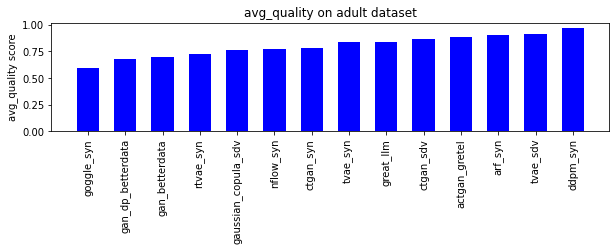

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [70]:
exp_dataset = "adult"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
subset = subset[subset['outliers_cov'] != -99]
plot_bar(subset, exp_dataset, eval_metric)

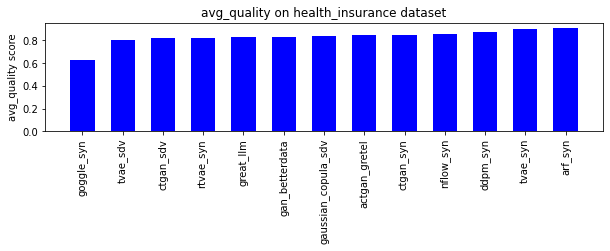

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [71]:
exp_dataset = "health_insurance"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

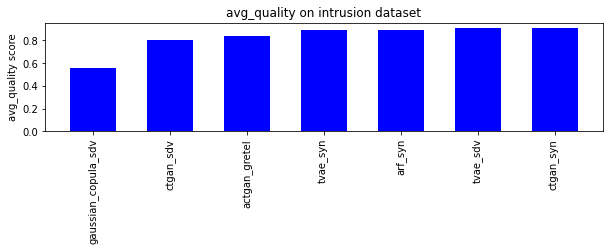

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [72]:
exp_dataset = "intrusion"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

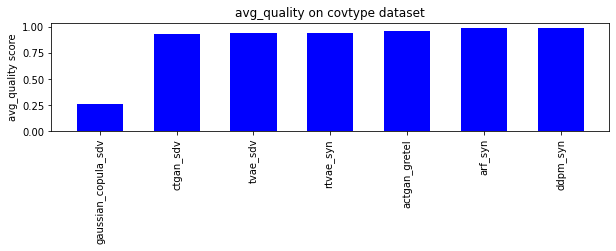

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [73]:
exp_dataset = "covtype"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

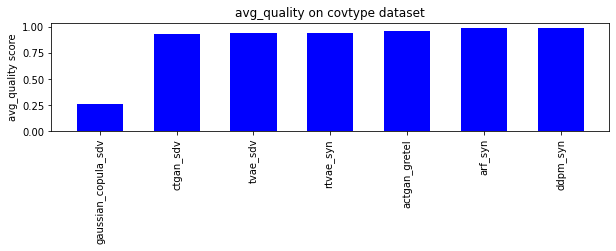

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [74]:
exp_dataset = "covtype"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

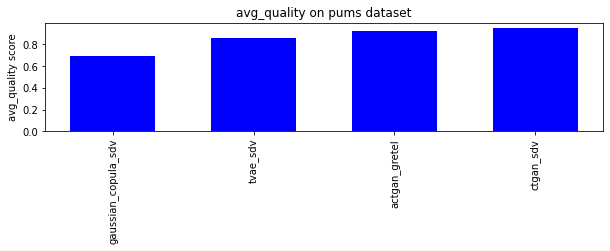

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [75]:
exp_dataset = "pums"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

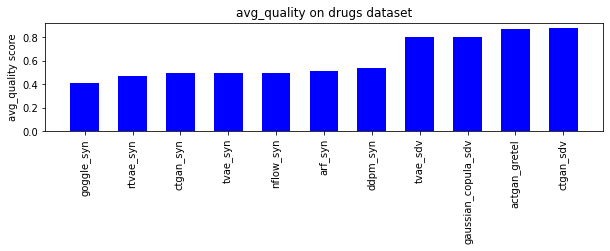

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [76]:
exp_dataset = "drugs"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

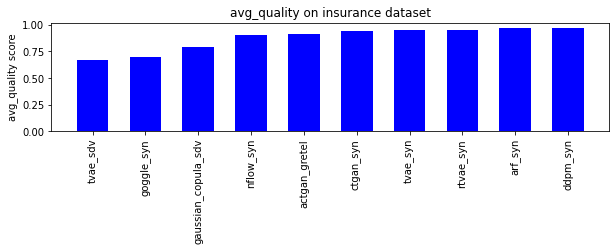

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [77]:
exp_dataset = "insurance"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

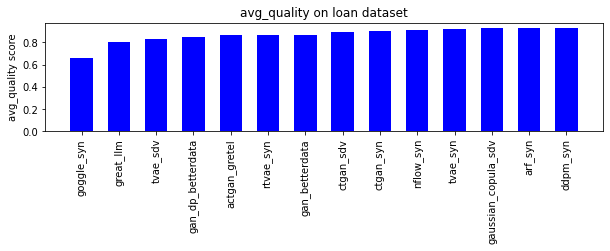

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [78]:
exp_dataset = "loan"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

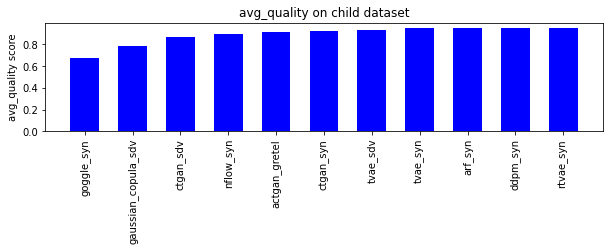

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [79]:
exp_dataset = "child"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

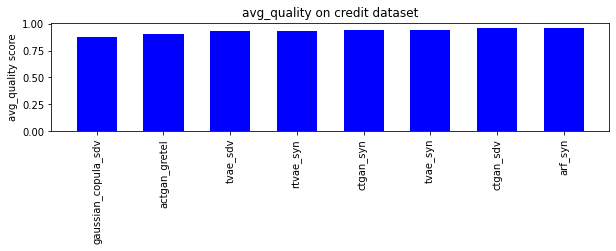

<module 'matplotlib.pyplot' from '/Users/anshusingh/.pyenv/versions/3.8.11/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [80]:
exp_dataset = "credit"
subset = all_df[(all_df["dataset"] == exp_dataset) & (all_df["case"] == "tabular")]
plot_bar(subset, exp_dataset, eval_metric)

### Analysis on datasets

In [81]:
all_df.shape

(123, 15)

In [118]:
subset = all_df[(all_df["dataset"] == "adult") & (all_df["case"] == "tabular")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
0,adult,actgan_gretel,tabular,0.89,0.99,0.49,1.00,0.79,0.92,0.97,0.87,0.88,0.02,0.24,1.00
1,adult,ctgan_sdv,tabular,0.87,0.99,0.79,1.00,0.87,0.91,0.98,0.82,0.87,0.02,0.22,1.00
2,adult,tvae_sdv,tabular,0.79,0.99,0.68,1.00,0.88,0.94,0.97,0.88,0.91,0.02,0.13,1.00
3,adult,gaussian_copula_sdv,tabular,0.92,0.95,0.41,1.00,0.70,0.80,0.99,0.73,0.76,0.07,0.29,1.00
4,adult,ctgan_syn,tabular,0.91,0.99,0.49,1.00,0.76,0.79,0.98,0.74,0.78,0.02,0.34,1.00
5,adult,tvae_syn,tabular,0.86,0.99,0.65,1.00,0.81,0.89,0.99,0.81,0.84,0.01,0.30,1.00
6,adult,goggle_syn,tabular,0.33,0.95,0.27,1.00,0.62,0.67,0.97,0.49,0.59,0.06,0.54,1.00
7,adult,arf_syn,tabular,0.99,1.00,0.81,1.00,0.88,0.91,0.99,0.87,0.90,0.01,0.16,1.00
8,adult,ddpm_syn,tabular,0.99,1.00,0.68,1.00,0.98,0.97,0.98,0.95,0.97,0.01,0.06,1.00
9,adult,nflow_syn,tabular,0.97,0.98,0.70,1.00,0.89,0.77,0.97,0.69,0.77,0.02,0.23,1.00


In [83]:
subset = all_df[(all_df["dataset"] == "credit") & (all_df["case"] == "tabular")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
38,credit,actgan_gretel,tabular,0.22,1.00,0.77,1.00,0.90,0.42,0.96,0.28,0.90,0.01,0.12,0.96
39,credit,ctgan_sdv,tabular,0.19,1.00,0.96,1.00,0.98,1.00,0.97,0.55,0.96,0.00,0.06,0.92
40,credit,tvae_sdv,tabular,0.15,0.99,0.37,1.00,0.93,1.00,0.96,0.54,0.93,0.01,0.14,0.72
41,credit,gaussian_copula_sdv,tabular,0.25,1.00,0.62,1.00,0.88,0.00,0.98,0.10,0.88,0.01,0.15,1.00
42,credit,ctgan_syn,tabular,0.56,1.00,0.80,1.00,0.93,1.00,0.97,0.64,0.94,0.01,0.08,0.99
43,credit,tvae_syn,tabular,0.47,1.00,0.63,1.00,0.93,1.00,0.98,0.62,0.94,0.01,0.08,0.98
44,credit,arf_syn,tabular,0.75,1.00,0.80,1.00,0.96,1.00,0.98,0.64,0.96,0.00,0.04,0.91
45,credit,rtvae_syn,tabular,0.37,1.00,0.61,1.00,0.92,1.00,0.97,0.55,0.93,0.01,0.11,1.00


In [84]:
subset = all_df[(all_df["dataset"] == "census") & (all_df["case"] == "tabular")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
14,census,actgan_gretel,tabular,0.92,0.97,0.41,1.00,0.87,0.91,0.98,0.88,0.89,0.02,0.20,0.98
15,census,tvae_sdv,tabular,0.91,0.98,0.38,1.00,0.93,0.95,0.98,0.92,0.93,0.02,0.10,0.90
16,census,gaussian_copula_sdv,tabular,0.93,0.89,0.29,1.00,0.50,0.77,0.98,0.64,0.68,0.11,0.42,1.00
17,census,arf_syn,tabular,0.99,0.98,0.50,1.00,0.89,0.92,0.98,0.88,0.90,0.03,0.09,0.98
18,census,ddpm_syn,tabular,0.85,0.60,0.00,1.00,0.49,0.58,0.92,0.40,0.49,0.39,0.52,1.00
19,census,gan_betterdata,tabular,0.93,0.97,0.45,1.00,0.96,0.92,0.97,0.53,0.73,0.02,0.07,1.00


In [85]:
subset = all_df[(all_df["dataset"] == "loan") & (all_df["case"] == "tabular")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
87,loan,actgan_gretel,tabular,0.99,0.96,0.40,1.00,0.83,0.89,0.92,0.85,0.87,0.05,0.16,1.00
88,loan,ctgan_sdv,tabular,0.97,0.97,0.37,1.00,0.85,0.93,0.91,0.88,0.89,0.04,0.15,1.00
89,loan,tvae_sdv,tabular,0.91,0.95,0.20,1.00,0.82,0.85,0.96,0.79,0.83,0.07,0.25,1.00
90,loan,gaussian_copula_sdv,tabular,0.94,0.98,0.39,1.00,0.89,0.97,0.97,0.91,0.93,0.03,0.19,1.00
91,loan,ctgan_syn,tabular,0.96,0.96,0.49,1.00,0.87,0.96,0.98,0.85,0.90,0.05,0.21,1.00
92,loan,tvae_syn,tabular,0.93,0.97,0.36,1.00,0.88,0.97,0.96,0.89,0.92,0.04,0.27,1.00
93,loan,goggle_syn,tabular,0.75,0.89,0.19,1.00,0.58,0.77,0.91,0.58,0.66,0.13,0.55,1.00
94,loan,arf_syn,tabular,1.00,0.99,0.33,1.00,0.89,0.98,0.97,0.91,0.93,0.02,0.15,1.00
95,loan,ddpm_syn,tabular,1.00,0.94,0.44,1.00,0.96,0.97,0.96,0.89,0.93,0.03,0.09,1.00
96,loan,nflow_syn,tabular,0.99,0.97,0.38,1.00,0.88,0.95,0.94,0.89,0.91,0.04,0.17,1.00


In [86]:
subset = all_df[(all_df["dataset"] == "health_insurance") & (all_df["case"] == "tabular")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
56,health_insurance,actgan_gretel,tabular,1.00,0.95,0.33,1.00,0.85,0.88,0.91,0.82,0.85,0.07,0.19,1.00
57,health_insurance,ctgan_sdv,tabular,0.98,0.89,0.35,1.00,0.75,0.88,0.89,0.81,0.82,0.13,0.24,1.00
58,health_insurance,tvae_sdv,tabular,0.91,0.95,0.67,1.00,0.81,0.82,0.98,0.74,0.80,0.07,0.20,1.00
59,health_insurance,gaussian_copula_sdv,tabular,0.93,0.95,0.11,1.00,0.85,0.87,0.94,0.80,0.84,0.07,0.18,1.00
60,health_insurance,ctgan_syn,tabular,0.92,0.94,0.32,1.00,0.86,0.88,0.98,0.80,0.85,0.07,0.21,1.00
61,health_insurance,tvae_syn,tabular,0.93,0.98,0.33,1.00,0.89,0.96,0.96,0.86,0.90,0.03,0.26,1.00
62,health_insurance,goggle_syn,tabular,0.56,0.90,0.00,1.00,0.63,0.73,0.92,0.51,0.63,0.10,0.55,1.00
63,health_insurance,arf_syn,tabular,1.00,0.97,0.57,1.00,0.90,0.94,0.95,0.88,0.91,0.04,0.12,0.96
64,health_insurance,ddpm_syn,tabular,1.00,0.95,0.67,1.00,0.89,0.91,0.92,0.83,0.87,0.07,0.21,1.00
65,health_insurance,nflow_syn,tabular,0.95,0.98,0.27,1.00,0.90,0.87,0.96,0.82,0.86,0.02,0.15,1.00


In [150]:
# subset = all_df[(all_df["dataset"] == "health_insurance") & (all_df["case"] == "tabular")]
# get_styled_df(subset, skip_cols, min_cols)   

In [98]:
subset = all_df[(all_df["dataset"] == "covtype") & (all_df["case"] == "tabular")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
31,covtype,actgan_gretel,tabular,0.98,0.99,0.80,1.00,0.94,0.98,0.97,0.95,0.96,0.02,0.11,1.00
32,covtype,ctgan_sdv,tabular,0.84,0.97,0.68,1.00,0.88,0.96,0.97,0.91,0.93,0.04,0.15,1.00
33,covtype,tvae_sdv,tabular,0.76,0.97,0.42,1.00,0.84,0.98,0.96,0.93,0.94,0.04,0.22,1.00
34,covtype,gaussian_copula_sdv,tabular,0.75,0.99,0.56,1.00,0.95,0.17,0.98,0.17,0.26,0.01,0.10,1.00
35,covtype,arf_syn,tabular,1.00,1.00,0.79,1.00,0.97,1.00,0.99,0.99,0.99,0.01,0.06,1.00
36,covtype,ddpm_syn,tabular,0.99,1.00,0.88,1.00,0.99,1.00,0.99,0.98,0.99,0.00,0.06,1.00
37,covtype,rtvae_syn,tabular,0.86,0.99,0.29,1.00,0.88,0.98,0.97,0.91,0.94,0.02,0.70,1.00


In [89]:
subset = all_df[(all_df["dataset"] == "pums") & (all_df["case"] == "tabular")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
101,pums,actgan_gretel,tabular,0.81,0.99,0.60,0.98,0.85,0.98,0.97,0.91,0.92,0.01,0.20,0.99
102,pums,ctgan_sdv,tabular,0.82,0.99,0.67,1.00,0.88,0.99,0.99,0.94,0.95,0.01,0.19,1.00
103,pums,tvae_sdv,tabular,0.80,0.97,0.63,1.00,0.81,0.92,0.95,0.82,0.86,0.04,0.29,1.00
104,pums,gaussian_copula_sdv,tabular,0.77,0.96,0.52,1.00,0.73,0.73,0.97,0.62,0.69,0.05,0.35,1.00


In [90]:
subset = all_df[(all_df["dataset"] == "credit") & (all_df["case"] == "tabular")]
get_styled_df(subset, skip_cols, min_cols)   

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
38,credit,actgan_gretel,tabular,0.22,1.00,0.77,1.00,0.90,0.42,0.96,0.28,0.90,0.01,0.12,0.96
39,credit,ctgan_sdv,tabular,0.19,1.00,0.96,1.00,0.98,1.00,0.97,0.55,0.96,0.00,0.06,0.92
40,credit,tvae_sdv,tabular,0.15,0.99,0.37,1.00,0.93,1.00,0.96,0.54,0.93,0.01,0.14,0.72
41,credit,gaussian_copula_sdv,tabular,0.25,1.00,0.62,1.00,0.88,0.00,0.98,0.10,0.88,0.01,0.15,1.00
42,credit,ctgan_syn,tabular,0.56,1.00,0.80,1.00,0.93,1.00,0.97,0.64,0.94,0.01,0.08,0.99
43,credit,tvae_syn,tabular,0.47,1.00,0.63,1.00,0.93,1.00,0.98,0.62,0.94,0.01,0.08,0.98
44,credit,arf_syn,tabular,0.75,1.00,0.80,1.00,0.96,1.00,0.98,0.64,0.96,0.00,0.04,0.91
45,credit,rtvae_syn,tabular,0.37,1.00,0.61,1.00,0.92,1.00,0.97,0.55,0.93,0.01,0.11,1.00


In [92]:
subset = all_df[(all_df["dataset"] == "child") & (all_df["case"] == "tabular")]
# get_styled_df(subset, skip_cols, min_cols)   
subset

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
20,child,actgan_gretel,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.93,NaN,0.89,0.91,-99.0,-99.0,0.79
21,child,ctgan_sdv,tabular,0.97,-99.0,-99.0,0.98,-99.0,0.90,NaN,0.84,0.87,-99.0,-99.0,0.89
22,child,tvae_sdv,tabular,0.97,-99.0,-99.0,0.98,-99.0,0.95,NaN,0.91,0.93,-99.0,-99.0,0.86
23,child,gaussian_copula_sdv,tabular,0.94,-99.0,-99.0,0.97,-99.0,0.85,NaN,0.71,0.78,-99.0,-99.0,1.00
24,child,ctgan_syn,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.94,NaN,0.90,0.92,-99.0,-99.0,0.86
25,child,tvae_syn,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.97,NaN,0.94,0.95,-99.0,-99.0,0.91
26,child,goggle_syn,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.75,NaN,0.59,0.67,-99.0,-99.0,0.85
27,child,arf_syn,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.96,NaN,0.93,0.95,-99.0,-99.0,0.84
28,child,ddpm_syn,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.96,NaN,0.94,0.95,-99.0,-99.0,0.85
29,child,nflow_syn,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.91,NaN,0.86,0.89,-99.0,-99.0,0.92


In [94]:
subset = all_df[(all_df["dataset"] == "drugs") & (all_df["case"] == "tabular")]
get_styled_df(subset[["dataset", "model", "case", "ks_sim", "tv_sim", "corr_sim", "avg_quality"]], skip_cols, min_cols)   

,dataset,model,case,ks_sim,tv_sim,corr_sim,avg_quality
76,drugs,actgan_gretel,tabular,0.87,0.92,0.94,0.87
77,drugs,ctgan_sdv,tabular,0.89,0.92,0.95,0.88
78,drugs,tvae_sdv,tabular,0.83,nan,0.99,0.80
79,drugs,gaussian_copula_sdv,tabular,0.92,0.88,0.97,0.80
80,drugs,ctgan_syn,tabular,0.89,0.85,0.93,0.50
81,drugs,tvae_syn,tabular,0.89,0.86,0.94,0.50
82,drugs,goggle_syn,tabular,0.85,0.74,0.95,0.41
83,drugs,arf_syn,tabular,0.91,0.86,0.94,0.51
84,drugs,ddpm_syn,tabular,0.93,0.90,0.93,0.54
85,drugs,nflow_syn,tabular,0.90,0.85,0.96,0.50


In [96]:
subset = all_df[(all_df["dataset"] == "insurance") & (all_df["case"] == "tabular")]
# get_styled_df(subset, skip_cols, min_cols)   
subset

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
46,insurance,actgan_gretel,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.93,NaN,0.89,0.91,-99.0,-99.0,0.94
47,insurance,tvae_sdv,tabular,0.93,-99.0,-99.0,0.95,-99.0,0.76,NaN,0.59,0.67,-99.0,-99.0,1.00
48,insurance,gaussian_copula_sdv,tabular,0.98,-99.0,-99.0,0.95,-99.0,0.85,NaN,0.73,0.79,-99.0,-99.0,1.00
49,insurance,ctgan_syn,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.96,NaN,0.93,0.94,-99.0,-99.0,0.91
50,insurance,tvae_syn,tabular,0.96,-99.0,-99.0,1.00,-99.0,0.96,NaN,0.94,0.95,-99.0,-99.0,0.95
51,insurance,goggle_syn,tabular,0.62,-99.0,-99.0,1.00,-99.0,0.77,NaN,0.62,0.70,-99.0,-99.0,0.93
52,insurance,arf_syn,tabular,0.99,-99.0,-99.0,1.00,-99.0,0.98,NaN,0.96,0.97,-99.0,-99.0,0.87
53,insurance,ddpm_syn,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.98,NaN,0.96,0.97,-99.0,-99.0,0.85
54,insurance,nflow_syn,tabular,1.00,-99.0,-99.0,1.00,-99.0,0.92,NaN,0.87,0.90,-99.0,-99.0,0.96
55,insurance,rtvae_syn,tabular,0.97,-99.0,-99.0,1.00,-99.0,0.97,NaN,0.94,0.95,-99.0,-99.0,0.94


### Machine learning efficacy analysis 

In [124]:
min_cols = ["linear_regression_diff", "mlp_regression_diff"]
subset = tabular_ml_reg_df
# df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
# df_style
get_styled_df(subset, skip_cols, min_cols) 

,dataset,model,case,linear_regression,linear_regression_diff,mlp_regression,mlp_regression_diff
0,health_insurance,actgan_gretel,tabular,0.16,0.55,-1.32,0.01
1,health_insurance,ctgan_sdv,tabular,-0.19,0.90,-1.32,0.01
2,health_insurance,tvae_sdv,tabular,0.58,0.12,-1.27,0.01
3,health_insurance,gaussian_copula_sdv,tabular,0.41,0.31,-1.31,0.01
4,health_insurance,ctgan_syn,tabular,0.71,0.00,-1.32,0.01
5,health_insurance,tvae_syn,tabular,0.66,0.05,-1.32,0.01
6,health_insurance,goggle_syn,tabular,-0.05,0.44,-2.03,0.02
7,health_insurance,arf_syn,tabular,0.71,0.00,-1.32,0.01
8,health_insurance,ddpm_syn,tabular,0.44,0.27,-1.32,0.01
9,health_insurance,nflow_syn,tabular,0.61,0.10,-1.32,0.01


In [125]:
tabular_ml_cls_df["dataset"].unique()
tabular_ml_cls_df = tabular_ml_cls_df.drop_duplicates()
tabular_ml_cls_df.shape

(56, 11)

In [126]:
tabular_ml_cls_df["dataset"].unique()

array(['adult', 'census', 'credit', 'covtype', 'loan', 'intrusion'],
      dtype=object)

In [127]:
# min_cols = ["linear_regression", "mlp_regression"]
# covtype, intrusion, 
min_cols = ["adaboost_classification_diff", "decision_tree_classification_diff", "logistic_classification_diff", "mlp_classification_diff"]
subset = tabular_ml_cls_df[(tabular_ml_cls_df["dataset"] == "adult")] #& (tabular_ml_cls_df["model"] == "ctgan_sdv")]
get_styled_df(subset[["dataset", "model"] + min_cols], skip_cols, min_cols)

,dataset,model,adaboost_classification_diff,decision_tree_classification_diff,logistic_classification_diff,mlp_classification_diff
0,adult,actgan_gretel,0.03,0.01,0.05,0.02
1,adult,ctgan_sdv,0.01,0.03,0.05,0.01
2,adult,tvae_sdv,0.01,0.02,0.05,0.03
3,adult,gaussian_copula_sdv,0.02,0.11,0.06,0.03
4,adult,ctgan_syn,0.04,0.08,0.06,0.02
5,adult,tvae_syn,0.02,0.07,0.08,0.01
6,adult,goggle_syn,0.06,0.31,0.23,0.10
7,adult,arf_syn,0.01,0.02,0.03,0.02
8,adult,ddpm_syn,0.01,0.02,0.03,0.02
9,adult,nflow_syn,0.03,0.05,0.09,0.03


In [128]:
subset = tabular_ml_cls_df[(tabular_ml_cls_df["dataset"] == "loan")] #& (tabular_ml_cls_df["model"] == "ctgan_sdv")]
get_styled_df(subset[["dataset", "model"] + min_cols], skip_cols, min_cols)

,dataset,model,adaboost_classification_diff,decision_tree_classification_diff,logistic_classification_diff,mlp_classification_diff
132,loan,actgan_gretel,0.39,0.58,0.13,0.41
133,loan,ctgan_sdv,0.84,0.80,0.37,0.87
134,loan,tvae_sdv,0.21,0.20,0.21,0.57
135,loan,gaussian_copula_sdv,0.58,0.61,0.16,0.81
136,loan,ctgan_syn,0.23,0.50,0.14,0.64
137,loan,tvae_syn,0.44,0.55,0.23,0.85
138,loan,goggle_syn,0.00,0.00,0.00,0.00
139,loan,arf_syn,0.21,0.37,0.10,0.79
140,loan,ddpm_syn,0.07,0.09,0.04,0.19
141,loan,nflow_syn,0.60,0.64,0.30,0.85


In [129]:
subset = tabular_ml_cls_df[(tabular_ml_cls_df["dataset"] == "census")] #& (tabular_ml_cls_df["model"] == "ctgan_sdv")]
get_styled_df(subset[["dataset", "model"] + min_cols], skip_cols, min_cols)

,dataset,model,adaboost_classification_diff,decision_tree_classification_diff,logistic_classification_diff,mlp_classification_diff
28,census,actgan_gretel,0.00,0.03,0.03,0.01
29,census,tvae_sdv,0.00,0.02,0.00,0.01
30,census,gaussian_copula_sdv,0.01,0.03,0.00,0.01
31,census,arf_syn,0.00,0.01,0.07,0.00
32,census,ddpm_syn,0.00,0.00,0.03,0.00
33,census,gan_betterdata,0.02,0.01,0.00,0.01


In [130]:
# subset = tabular_ml_cls_df[(tabular_ml_cls_df["dataset"] == "covtype")] #& (tabular_ml_cls_df["model"] == "ctgan_sdv")]
# subset

In [131]:
subset = tabular_ml_cls_df[(tabular_ml_cls_df["dataset"] == "credit")] #& (tabular_ml_cls_df["model"] == "ctgan_sdv")]
get_styled_df(subset[["dataset", "model"] + min_cols], skip_cols, min_cols)

,dataset,model,adaboost_classification_diff,decision_tree_classification_diff,logistic_classification_diff,mlp_classification_diff
54,credit,actgan_gretel,0.71,0.33,0.09,0.78
55,credit,ctgan_sdv,0.00,0.00,0.00,0.00
56,credit,tvae_sdv,0.00,0.00,0.00,0.00
57,credit,gaussian_copula_sdv,0.19,0.11,0.06,0.14
58,credit,ctgan_syn,0.71,0.34,0.10,0.79
59,credit,tvae_syn,0.63,0.33,0.28,0.79
60,credit,arf_syn,0.07,0.00,0.05,0.08
61,credit,rtvae_syn,0.73,0.34,0.10,0.78


In [132]:
subset = tabular_ml_cls_df[(tabular_ml_cls_df["dataset"] == "intrusion")] #& (tabular_ml_cls_df["model"] == "ctgan_sdv")]
# df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
# df_style
subset

,dataset,model,case,adaboost_classification,adaboost_classification_diff,decision_tree_classification,decision_tree_classification_diff,logistic_classification,logistic_classification_diff,mlp_classification,mlp_classification_diff
195,intrusion,actgan_gretel,tabular,1.00,0.00,1.00,0.00,1.00,0.03,1.00,0.00
196,intrusion,ctgan_sdv,tabular,1.00,0.00,1.00,0.00,1.00,0.02,1.00,0.00
197,intrusion,tvae_sdv,tabular,1.00,0.00,0.99,0.01,1.00,0.03,1.00,0.00
198,intrusion,gaussian_copula_sdv,tabular,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00
199,intrusion,ctgan_syn,tabular,0.99,0.01,0.98,0.02,0.98,0.01,0.99,0.01
200,intrusion,tvae_syn,tabular,1.00,0.00,1.00,0.00,0.97,0.00,1.00,0.00
201,intrusion,arf_syn,tabular,1.00,0.00,1.00,0.00,0.97,0.00,1.00,0.00


### Imputation analysis

In [133]:
skip_cols = ['dataset', 'model', 'case']
min_cols = ["wass_dist", "js_dist"]

In [134]:
all_df["model"].unique()

subset = all_df[(all_df["dataset"] == "drugs") & (all_df["model"] == "ctgan_sdv") & ~(all_df['case'].str.contains('only_'))]
# subset = subset[subset['new_row_synthesis'] != -99]

subset = subset.drop('new_rows', axis=1)
subset = subset.drop('missing_cov', axis=1)

df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style
# subset

,dataset,model,case,domain_cov,stats_cov,outliers_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist
77,drugs,ctgan_sdv,tabular,0.890000,0.960000,1.000000,0.890000,0.920000,0.950000,0.830000,0.880000,0.060000,0.140000
105,drugs,ctgan_sdv,missforest,0.920000,0.990000,0.000000,0.950000,0.880000,0.920000,0.170000,0.530000,0.010000,0.070000
107,drugs,ctgan_sdv,ice,0.960000,0.930000,0.000000,0.900000,0.890000,0.950000,0.170000,0.530000,0.090000,0.220000
109,drugs,ctgan_sdv,hyperimpute,0.950000,0.920000,1.000000,0.850000,0.900000,0.960000,0.170000,0.530000,0.120000,0.270000
111,drugs,ctgan_sdv,simple,0.900000,0.980000,0.000000,0.940000,0.890000,0.960000,0.170000,0.530000,0.030000,0.100000


### Model analysis

In [151]:
subset = all_df[(all_df["model"] == "ctgan_sdv")  & (all_df["case"] == "tabular")]
# df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
# df_style
subset

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
1,adult,ctgan_sdv,tabular,0.87,0.99,0.79,1.00,0.87,0.91,0.98,0.82,0.87,0.02,0.22,1.00
21,child,ctgan_sdv,tabular,0.97,-99.00,-99.00,0.98,-99.00,0.90,NaN,0.84,0.87,-99.00,-99.00,0.89
32,covtype,ctgan_sdv,tabular,0.84,0.97,0.68,1.00,0.88,0.96,0.97,0.91,0.93,0.04,0.15,1.00
39,credit,ctgan_sdv,tabular,0.19,1.00,0.96,1.00,0.98,1.00,0.97,0.55,0.96,0.00,0.06,0.92
57,health_insurance,ctgan_sdv,tabular,0.98,0.89,0.35,1.00,0.75,0.88,0.89,0.81,0.82,0.13,0.24,1.00
70,intrusion,ctgan_sdv,tabular,0.67,0.86,0.36,1.00,0.77,0.88,0.92,0.74,0.80,0.12,0.22,0.98
77,drugs,ctgan_sdv,tabular,0.89,0.96,1.00,0.95,0.89,0.92,0.95,0.83,0.88,0.06,0.14,-99.00
88,loan,ctgan_sdv,tabular,0.97,0.97,0.37,1.00,0.85,0.93,0.91,0.88,0.89,0.04,0.15,1.00
102,pums,ctgan_sdv,tabular,0.82,0.99,0.67,1.00,0.88,0.99,0.99,0.94,0.95,0.01,0.19,1.00


### Model analysis across libraries 

#### CTGAN_SDV, CTGAN_SYTHCITY, ACTGAN_GRETEL 

In [136]:
subset = all_df[all_df["model"].isin(["ctgan_syn", "ctgan_sdv", "actgan_gretel"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "adult")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
0,adult,actgan_gretel,tabular,0.890000,0.990000,0.490000,1.000000,0.790000,0.920000,0.970000,0.870000,0.880000,0.020000,0.240000,1.000000
1,adult,ctgan_sdv,tabular,0.870000,0.990000,0.790000,1.000000,0.870000,0.910000,0.980000,0.820000,0.870000,0.020000,0.220000,1.000000
4,adult,ctgan_syn,tabular,0.910000,0.990000,0.490000,1.000000,0.760000,0.790000,0.980000,0.740000,0.780000,0.020000,0.340000,1.000000


In [137]:
subset = all_df[all_df["model"].isin(["ctgan_syn", "ctgan_sdv", "actgan_gretel"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "health_insurance")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
56,health_insurance,actgan_gretel,tabular,1.000000,0.950000,0.330000,1.000000,0.850000,0.880000,0.910000,0.820000,0.850000,0.070000,0.190000,1.000000
57,health_insurance,ctgan_sdv,tabular,0.980000,0.890000,0.350000,1.000000,0.750000,0.880000,0.890000,0.810000,0.820000,0.130000,0.240000,1.000000
60,health_insurance,ctgan_syn,tabular,0.920000,0.940000,0.320000,1.000000,0.860000,0.880000,0.980000,0.800000,0.850000,0.070000,0.210000,1.000000


In [138]:
subset = all_df[all_df["model"].isin(["ctgan_syn", "ctgan_sdv", "actgan_gretel"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "intrusion")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
69,intrusion,actgan_gretel,tabular,0.740000,0.890000,0.360000,1.000000,0.830000,0.910000,0.960000,0.780000,0.840000,0.070000,0.180000,0.980000
70,intrusion,ctgan_sdv,tabular,0.670000,0.860000,0.360000,1.000000,0.770000,0.880000,0.920000,0.740000,0.800000,0.120000,0.220000,0.980000
73,intrusion,ctgan_syn,tabular,0.960000,0.900000,0.650000,1.000000,0.780000,0.960000,0.980000,0.910000,0.910000,0.020000,0.170000,1.000000


In [139]:
subset = all_df[all_df["model"].isin(["ctgan_syn", "ctgan_sdv", "actgan_gretel"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "credit")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
38,credit,actgan_gretel,tabular,0.220000,1.000000,0.770000,1.000000,0.900000,0.420000,0.960000,0.280000,0.900000,0.010000,0.120000,0.960000
39,credit,ctgan_sdv,tabular,0.190000,1.000000,0.960000,1.000000,0.980000,1.000000,0.970000,0.550000,0.960000,0.000000,0.060000,0.920000
42,credit,ctgan_syn,tabular,0.560000,1.000000,0.800000,1.000000,0.930000,1.000000,0.970000,0.640000,0.940000,0.010000,0.080000,0.990000


In [140]:
subset = all_df[all_df["model"].isin(["ctgan_syn", "ctgan_sdv", "actgan_gretel"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "loan")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
87,loan,actgan_gretel,tabular,0.990000,0.960000,0.400000,1.000000,0.830000,0.890000,0.920000,0.850000,0.870000,0.050000,0.160000,1.000000
88,loan,ctgan_sdv,tabular,0.970000,0.970000,0.370000,1.000000,0.850000,0.930000,0.910000,0.880000,0.890000,0.040000,0.150000,1.000000
91,loan,ctgan_syn,tabular,0.960000,0.960000,0.490000,1.000000,0.870000,0.960000,0.980000,0.850000,0.900000,0.050000,0.210000,1.000000


In [141]:
subset = all_df[all_df["model"].isin(["ctgan_syn", "ctgan_sdv", "actgan_gretel"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "pums")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
101,pums,actgan_gretel,tabular,0.810000,0.990000,0.600000,0.980000,0.850000,0.980000,0.970000,0.910000,0.920000,0.010000,0.200000,0.990000
102,pums,ctgan_sdv,tabular,0.820000,0.990000,0.670000,1.000000,0.880000,0.990000,0.990000,0.940000,0.950000,0.010000,0.190000,1.000000


In [142]:
subset = all_df[all_df["model"].isin(["ctgan_syn", "ctgan_sdv", "actgan_gretel"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "drugs")]
# df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
# df_style
subset 

# ctgan_sdv

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
76,drugs,actgan_gretel,tabular,0.90,0.96,0.0,0.95,0.87,0.92,0.94,0.82,0.87,0.05,0.18,-99.0
77,drugs,ctgan_sdv,tabular,0.89,0.96,1.0,0.95,0.89,0.92,0.95,0.83,0.88,0.06,0.14,-99.0
80,drugs,ctgan_syn,tabular,-99.00,-99.00,-99.0,-99.00,0.89,0.85,0.93,0.14,0.50,-99.00,-99.00,-99.0


In [143]:
subset = all_df[all_df["model"].isin(["ctgan_syn", "ctgan_sdv", "actgan_gretel"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "census")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
14,census,actgan_gretel,tabular,0.920000,0.970000,0.410000,1.000000,0.870000,0.910000,0.980000,0.880000,0.890000,0.020000,0.200000,0.980000


#### TVAE_SDV, TVAE_SYNTHCITY, RTVAE_SYNTHCITY

In [144]:
subset = all_df[all_df["model"].isin(["rtvae_syn", "tvae_sdv", "tvae_syn"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "adult")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style


,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
2,adult,tvae_sdv,tabular,0.790000,0.990000,0.680000,1.000000,0.880000,0.940000,0.970000,0.880000,0.910000,0.020000,0.130000,1.000000
5,adult,tvae_syn,tabular,0.860000,0.990000,0.650000,1.000000,0.810000,0.890000,0.990000,0.810000,0.840000,0.010000,0.300000,1.000000
10,adult,rtvae_syn,tabular,0.730000,0.980000,0.390000,1.000000,0.770000,0.740000,0.980000,0.650000,0.730000,0.020000,0.480000,1.000000


In [145]:
subset = all_df[all_df["model"].isin(["rtvae_syn", "tvae_sdv", "tvae_syn"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "health_insurance")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
58,health_insurance,tvae_sdv,tabular,0.910000,0.950000,0.670000,1.000000,0.810000,0.820000,0.980000,0.740000,0.800000,0.070000,0.200000,1.000000
61,health_insurance,tvae_syn,tabular,0.930000,0.980000,0.330000,1.000000,0.890000,0.960000,0.960000,0.860000,0.900000,0.030000,0.260000,1.000000
66,health_insurance,rtvae_syn,tabular,0.830000,0.960000,0.000000,1.000000,0.780000,0.960000,0.900000,0.730000,0.820000,0.070000,0.530000,1.000000


In [146]:
subset = all_df[all_df["model"].isin(["rtvae_syn", "tvae_sdv", "tvae_syn"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "drugs")]
# df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
# df_style
subset

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
78,drugs,tvae_sdv,tabular,0.77,0.93,0.0,0.95,0.83,NaN,0.99,0.76,0.80,0.06,0.18,-99.0
81,drugs,tvae_syn,tabular,-99.00,-99.00,-99.0,-99.00,0.89,0.86,0.94,0.15,0.50,-99.00,-99.00,-99.0
86,drugs,rtvae_syn,tabular,-99.00,-99.00,-99.0,-99.00,0.74,0.82,0.92,0.11,0.47,-99.00,-99.00,-99.0


In [147]:
subset = all_df[all_df["model"].isin(["rtvae_syn", "tvae_sdv", "tvae_syn"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "loan")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
89,loan,tvae_sdv,tabular,0.910000,0.950000,0.200000,1.000000,0.820000,0.850000,0.960000,0.790000,0.830000,0.070000,0.250000,1.000000
92,loan,tvae_syn,tabular,0.930000,0.970000,0.360000,1.000000,0.880000,0.970000,0.960000,0.890000,0.920000,0.040000,0.270000,1.000000
97,loan,rtvae_syn,tabular,0.860000,0.970000,0.400000,1.000000,0.850000,0.960000,0.950000,0.810000,0.870000,0.040000,0.480000,1.000000


In [148]:
subset = all_df[all_df["model"].isin(["rtvae_syn", "tvae_sdv", "tvae_syn"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "intrusion")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
71,intrusion,tvae_sdv,tabular,0.630000,0.990000,0.150000,1.000000,0.910000,0.970000,0.930000,0.870000,0.910000,0.020000,0.150000,0.960000
74,intrusion,tvae_syn,tabular,0.760000,0.950000,0.350000,1.000000,0.810000,0.950000,0.970000,0.870000,0.890000,0.020000,0.180000,0.990000


In [149]:
subset = all_df[all_df["model"].isin(["rtvae_syn", "tvae_sdv", "tvae_syn"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "credit")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,avg_quality,wass_dist,js_dist,new_rows
40,credit,tvae_sdv,tabular,0.150000,0.990000,0.370000,1.000000,0.930000,1.000000,0.960000,0.540000,0.930000,0.010000,0.140000,0.720000
43,credit,tvae_syn,tabular,0.470000,1.000000,0.630000,1.000000,0.930000,1.000000,0.980000,0.620000,0.940000,0.010000,0.080000,0.980000
45,credit,rtvae_syn,tabular,0.370000,1.000000,0.610000,1.000000,0.920000,1.000000,0.970000,0.550000,0.930000,0.010000,0.110000,1.000000
